In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Timedelta
from datetime import datetime
from datetime import timedelta
from time import time
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from statsmodels.tsa.arima.model import ARIMA

### Ice Cream Production Data

In [106]:
#read data
production_ice_cream=pd.read_csv('ice_cream.csv',parse_dates=[0],index_col=0,date_format='%Y-%m-%d').squeeze()
# squeeze() Squeeze 1 dimensional axis objects into scalars. as 0th columns is now index we are just left with 1 dimensional\
# axis which we convert to series using squeeze()

In [107]:
production_ice_cream.rename('production',inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [108]:
# infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))
#pd.infer_freq() Infer the most likely frequency given the input index. If the frequency is uncertain, a warning will be printed.
# df.asfreq() Convert time series to specified frequency.

In [109]:
# getting data form 2010 onwards
start_date=pd.to_datetime('2010-01-01')
production_ice_cream  = production_ice_cream[start_date:]

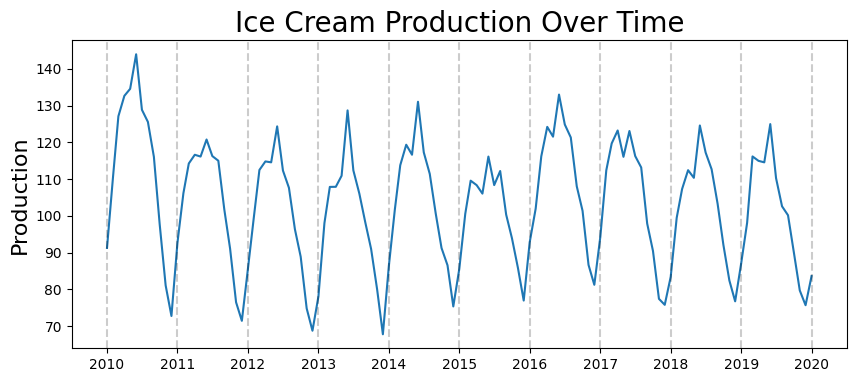

In [110]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production Over Time',fontsize=20)
plt.ylabel('Production',fontsize=16)
for year in range(2010,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.2)

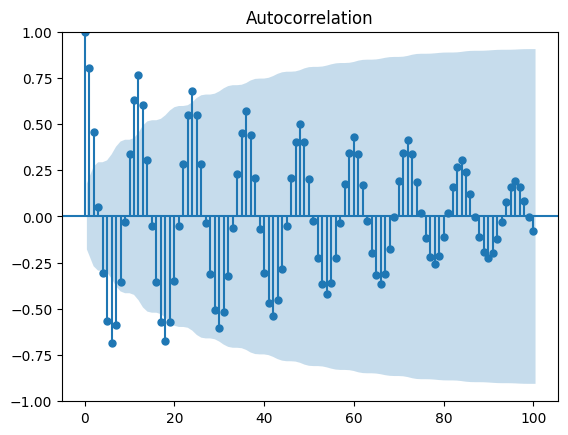

In [111]:
acf_plot=plot_acf(production_ice_cream,lags=100)
#An int or array of lag values, used on horizontal axis. Uses np.arange(lags) when lags is an int. If not provided, lags=np.arange(len(corr)) is used.

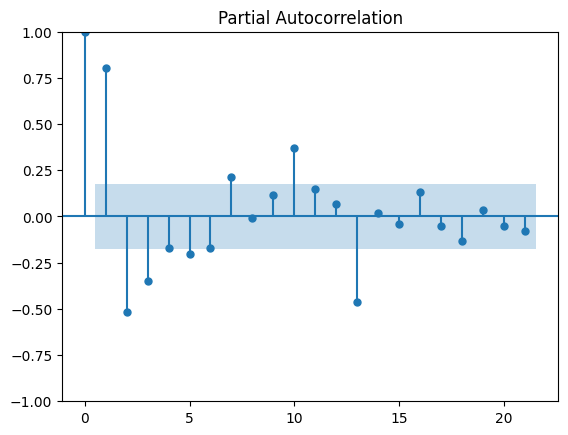

In [112]:
pacf_plot=plot_pacf(production_ice_cream)

#### Based on PACF, we should start with an Auto regressive model with lags 1,2,3

Getting Training and testing data

In [113]:
train_end = datetime(2018,12,1)
test_end  = datetime(2019,12,1)
train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]
# tinmedate() generally used for calculating differences in dates and also can be used for date manipulations

Fit the AR Model

In [114]:
# creating the model 
model = ARIMA(train_data,order=(3,0,0))

In [115]:
# fir the model
start=time()
model_fit = model.fit()
end=time()
print('Model fitting Time:',end-start)

Model fitting Time: 0.0831451416015625


In [116]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Fri, 08 Mar 2024   AIC                            758.170
Time:                        22:37:30   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

>since for lag 2(ar.L2) p_value is greater than 0.5 it can be omitted from our AR model, so we will build the model with lag1 and lag3 excluding lag2

In [117]:
# get prediction start and end date
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [118]:
# get predictions and residuals
predictions=model_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data-predictions

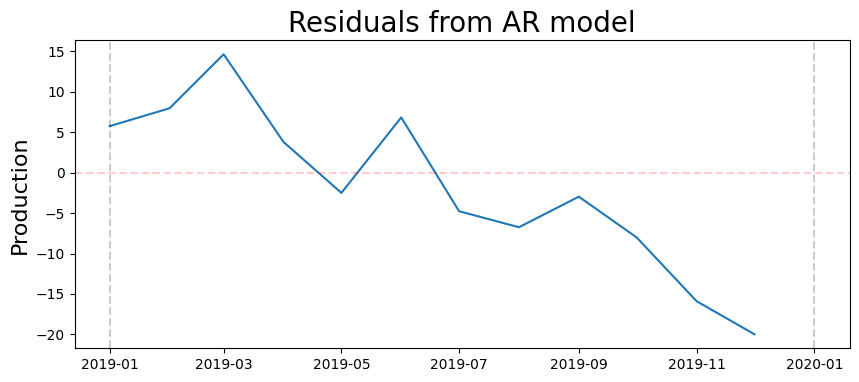

In [119]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR model',fontsize=20)
plt.ylabel('Production',fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2019,2021):

    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.2)

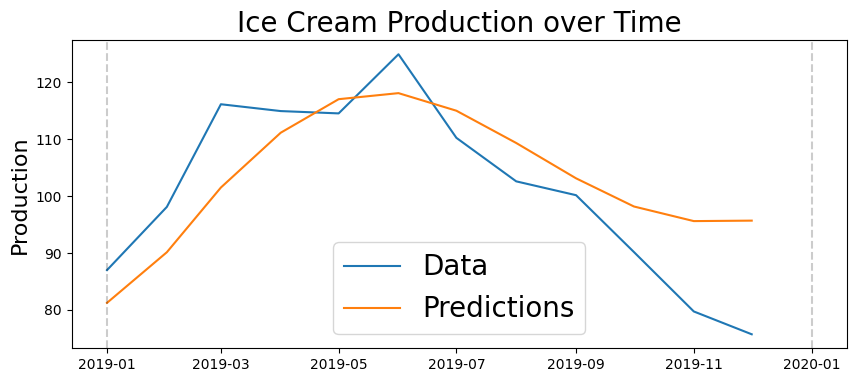

In [120]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data','Predictions'),fontsize=20)

plt.title('Ice Cream Production over Time',fontsize=20)
plt.ylabel('Production',fontsize=16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.2)

In [121]:
print('Mean Absolute Percent Error:',np.mean(abs(residuals/test_data)))

Mean Absolute Percent Error: 0.08951274994373508


In [122]:
print('Root Mean Squared Error:',np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 9.884158751659836
